# Supervised Learning Model Evaluation - In-Class Exercises

In this notebook, you will practice evaluating supervised learning models using proper train-test splitting strategies, computing various evaluation metrics, and performing cross-validation with confidence intervals.

**Datasets:**
- **Titanic**: Binary classification (Survived: 0 or 1) - imbalanced dataset
- **Iris**: Multiclass classification (3 species) - balanced dataset

**Learning Objectives:**
- Implement proper train-test splitting strategies
- Compute and interpret evaluation metrics for binary and multiclass problems
- Calculate ROC curves
- Perform cross-validation with confidence intervals

## Setup: Import Libraries

All necessary imports are provided below.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report
)

# Set random seed for reproducibility
np.random.seed(42)

---
## Part 1: Binary Classification - Titanic Dataset

### Dataset Loading and Preprocessing

The code below loads and preprocesses the Titanic dataset. This is provided for you.

In [2]:
# Load Titanic dataset
titanic = sns.load_dataset('titanic')

# Display first few rows and info
print("Dataset shape:", titanic.shape)
print("\nFirst few rows:")
display(titanic.head())
print("\nMissing values:")
print(titanic.isnull().sum())
print("\nClass distribution:")
print(titanic['survived'].value_counts())

Dataset shape: (891, 15)

First few rows:


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True



Missing values:
survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Class distribution:
survived
0    549
1    342
Name: count, dtype: int64


In [3]:
# Preprocessing: Select features and handle missing values
# Select relevant features
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
target = 'survived'

# Create a copy with selected features
df_titanic = titanic[features + [target]].copy()

# Handle missing values
# Fill missing age with median
df_titanic['age'] = df_titanic['age'].fillna(df_titanic['age'].median())

# Fill missing embarked with mode
df_titanic['embarked'] = df_titanic['embarked'].fillna(df_titanic['embarked'].mode()[0])

# Fill missing fare with median
df_titanic['fare'] = df_titanic['fare'].fillna(df_titanic['fare'].median())

# Encode categorical variables
df_titanic['sex'] = df_titanic['sex'].map({'male': 0, 'female': 1})
df_titanic = pd.get_dummies(df_titanic, columns=['embarked'], prefix='embarked', drop_first=True)

# Separate features and target
X_titanic = df_titanic.drop(target, axis=1)
y_titanic = df_titanic[target]

print("Preprocessed dataset shape:", X_titanic.shape)
print("Features:", list(X_titanic.columns))
print("\nNo missing values remaining:", X_titanic.isnull().sum().sum())

Preprocessed dataset shape: (891, 8)
Features: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked_Q', 'embarked_S']

No missing values remaining: 0


---
## ✏️ Exercise 1: Train-Test Split with Stratification

**Task:** Create a train-test split for the Titanic dataset.

**Requirements:**
- Use 70% of the data for training and 30% for testing
- Set `random_state=42` for reproducibility
- Store the results in variables: `X_train_titanic`, `X_test_titanic`, `y_train_titanic`, `y_test_titanic`

*Tip: For imbalanced datasets like Titanic, consider whether you want the same class distribution in both train and test sets. Check the `stratify` parameter in the documentation.*

In [20]:
# ===== STUDENT CODE START =====
# split the dataset into testing and training and stratify the data
X_train_titanic, X_test_titanic, y_train_titanic, y_test_titanic = train_test_split(X_titanic, y_titanic, test_size=0.3, random_state=42, stratify=y_titanic)

# ===== STUDENT CODE END =====

In [21]:
# Verify the split by checking shapes and class distributions
print("Train set shape:", X_train_titanic.shape)
print("Test set shape:", X_test_titanic.shape)
print("\nTrain set class distribution:")
print(y_train_titanic.value_counts(normalize=True))
print("\nTest set class distribution:")
print(y_test_titanic.value_counts(normalize=True))

Train set shape: (623, 8)
Test set shape: (268, 8)

Train set class distribution:
survived
0    0.616372
1    0.383628
Name: proportion, dtype: float64

Test set class distribution:
survived
0    0.615672
1    0.384328
Name: proportion, dtype: float64


### Model Training Code 

Below is the model training code. **Warning** - you will need to create the train-test split first in Exercise 1.

In [22]:
# Train a Logistic Regression model
# This cell should be run AFTER you complete Exercise 1

model_titanic = LogisticRegression(max_iter=1000, random_state=42)
model_titanic.fit(X_train_titanic, y_train_titanic)

# Make predictions
y_pred_titanic = model_titanic.predict(X_test_titanic)
y_pred_proba_titanic = model_titanic.predict_proba(X_test_titanic)[:, 1]

print("Model trained successfully!")

Model trained successfully!


---
## ✏️ Exercise 2: Binary Classification Evaluation Metrics

**Task:** Calculate the following evaluation metrics for the Titanic model:
1. Confusion Matrix
2. Accuracy
3. Precision
4. Recall
5. F1-Score
6. ROC-AUC Score

**Visualization Requirements:**
- Create a heatmap visualization of the confusion matrix using seaborn
- Plot the ROC curve with AUC score using matplotlib

*Tip: All these functions are available in `sklearn.metrics`. For ROC-AUC, you'll need predicted probabilities, not just class predictions.*

TITANIC DATASET - Binary Classification Metrics
TITANIC DATASET - Binary Classification Metrics

Confusion Matrix:
[[139  26]
 [ 28  75]]

Accuracy: 0.7985
Precision: 0.7426
Recall: 0.7282
F1-Score: 0.7353
ROC-AUC Score: 0.8495


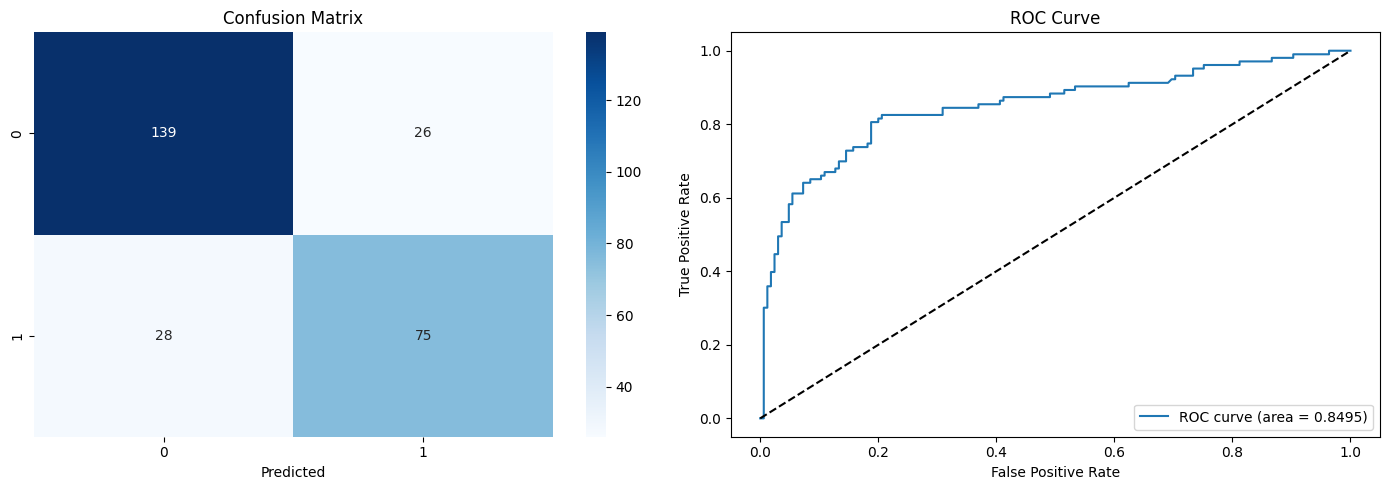

In [23]:
# ===== STUDENT CODE START =====
confusion_matrix_titanic = confusion_matrix(y_test_titanic, y_pred_titanic)
accuracy_titanic = accuracy_score(y_test_titanic, y_pred_titanic)
precision_titanic = precision_score(y_test_titanic, y_pred_titanic)
recall_titanic = recall_score(y_test_titanic, y_pred_titanic)
f1_titanic = f1_score(y_test_titanic, y_pred_titanic)
roc_auc_titanic = roc_auc_score(y_test_titanic, y_pred_proba_titanic)

# ===== STUDENT CODE END =====

# Print results
print("="*60)
print("TITANIC DATASET - Binary Classification Metrics")
print("="*60)
print("TITANIC DATASET - Binary Classification Metrics")
print("="*60)
print("\nConfusion Matrix:")
print(confusion_matrix_titanic)
print(f"\nAccuracy: {accuracy_titanic:.4f}")
print(f"Precision: {precision_titanic:.4f}")
print(f"Recall: {recall_titanic:.4f}")
print(f"F1-Score: {f1_titanic:.4f}")
print(f"ROC-AUC Score: {roc_auc_titanic:.4f}")

# Visualizations
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap and ROC Curve
# ===== STUDENT CODE START =====

# make the plots for the confusion matrix and ROC curve
sns.heatmap(confusion_matrix_titanic, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')

# roc curve
fpr, tpr, thresholds = roc_curve(y_test_titanic, y_pred_proba_titanic)
axes[1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_titanic:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--')  # Diagonal
axes[1].set_title('ROC Curve')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc='lower right')
plt.tight_layout()
plt.show()

# ===== STUDENT CODE END =====


---
## Part 2: Multiclass Classification - Iris Dataset

### Dataset Loading

The Iris dataset is balanced and clean, requiring minimal preprocessing.

In [24]:
# Load Iris dataset
iris = load_iris()
X_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
y_iris = iris.target

print("Dataset shape:", X_iris.shape)
print("Target classes:", iris.target_names)
print("\nClass distribution:")
print(pd.Series(y_iris).value_counts().sort_index())
print("\nFirst few rows:")
display(X_iris.head())

print("\n" + "="*60)
print("Feature Statistics (Before Scaling)")
print("="*60)
display(X_iris.describe())

Dataset shape: (150, 4)
Target classes: ['setosa' 'versicolor' 'virginica']

Class distribution:
0    50
1    50
2    50
Name: count, dtype: int64

First few rows:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2



Feature Statistics (Before Scaling)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [25]:
# Preprocessing: Feature Scaling
# Many sklearn models (e.g., Logistic Regression, SVM, KNN) benefit from scaled features
# StandardScaler standardizes features by removing the mean and scaling to unit variance

scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)
X_iris = pd.DataFrame(X_iris_scaled, columns=iris.feature_names)

print("="*60)
print("Feature Statistics (After Scaling)")
print("="*60)
display(X_iris.describe())
print("\nFeatures are now scaled with mean ≈ 0 and std ≈ 1")
print("This improves performance for distance-based and gradient-based models")

Feature Statistics (After Scaling)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02
mean,-1.468455e-15,-1.823726e-15,-1.610564e-15,-9.473903e-16
std,1.003350e+00,1.003350e+00,1.003350e+00,1.003350e+00
min,-1.870024e+00,-2.433947e+00,-1.567576e+00,-1.447076e+00
25%,-9.006812e-01,-5.923730e-01,-1.226552e+00,-1.183812e+00
50%,-5.250608e-02,-1.319795e-01,3.364776e-01,1.325097e-01
75%,6.745011e-01,5.586108e-01,7.627583e-01,7.906707e-01
max,2.492019e+00,3.090775e+00,1.785832e+00,1.712096e+00



Features are now scaled with mean ≈ 0 and std ≈ 1
This improves performance for distance-based and gradient-based models


---
## ✏️ Exercise 3: Train-Test Split for Balanced Dataset

**Task:** Create a train-test split for the Iris dataset.

**Requirements:**
- Use 70% of the data for training and 30% for testing
- Set `random_state=42` for reproducibility
- Store the results in variables: `X_train_iris`, `X_test_iris`, `y_train_iris`, `y_test_iris`

*Note: Since Iris is a balanced dataset, stratification is optional but still good practice.*

In [26]:
# ===== STUDENT CODE START =====
# split the data into training and testing sets
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.3, random_state=42, stratify=y_iris)

# ===== STUDENT CODE END =====

In [27]:
# Verify the split
print("Train set shape:", X_train_iris.shape)
print("Test set shape:", X_test_iris.shape)
print("\nTrain set class distribution:")
print(pd.Series(y_train_iris).value_counts().sort_index())
print("\nTest set class distribution:")
print(pd.Series(y_test_iris).value_counts().sort_index())

Train set shape: (105, 4)
Test set shape: (45, 4)

Train set class distribution:
0    35
1    35
2    35
Name: count, dtype: int64

Test set class distribution:
0    15
1    15
2    15
Name: count, dtype: int64


### Model Training Code

Below is the model training code. **Warning** - complete Exercise 3 first.

In [39]:
# Train a Logistic Regression model for multiclass classification
# This cell should be run AFTER you complete Exercise 3

model_iris = LogisticRegression(max_iter=1000, random_state=42)
model_iris.fit(X_train_iris, y_train_iris)

# Make predictions
y_pred_iris = model_iris.predict(X_test_iris)
y_pred_proba_iris = model_iris.predict_proba(X_test_iris)

print("Model trained successfully!")
print(f"Training set size: {len(X_train_iris)}")
print(f"Test set size: {len(X_test_iris)}")

Model trained successfully!
Training set size: 105
Test set size: 45


---
## ✏️ Exercise 4: Multiclass Classification Evaluation Metrics

**Task:** Calculate the following evaluation metrics for the Iris model:
1. Confusion Matrix
2. Overall Accuracy
3. Precision (macro, micro, and weighted averages)
4. Recall (macro, micro, and weighted averages)
5. F1-Score (macro, micro, and weighted averages)

**Visualization Requirement:**
- Create a heatmap visualization of the confusion matrix using seaborn with proper class labels

*Tip: For multiclass metrics, check the `average` parameter. Different averaging methods give you different perspectives on model performance.*

**'macro':** (Default in many functions): Calculates the metric for each label and finds their unweighted mean. This does not take label imbalance into account.

**'weighted':** Calculates the metric for each label and finds their average, weighted by support (the number of true instances for each label). This accounts for label imbalance.

**'micro':** Calculates metrics globally by counting the total true positives, false negatives, and false positives.*

IRIS DATASET - Multiclass Classification Metrics

Confusion Matrix:
[[15  0  0]
 [ 0 14  1]
 [ 0  3 12]]

Overall Accuracy: 0.9111

Precision:
  Macro:    0.9155
  Micro:    0.9111
  Weighted: 0.9155

Recall:
  Macro:    0.9111
  Micro:    0.9111
  Weighted: 0.9111

F1-Score:
  Macro:    0.9107
  Micro:    0.9111
  Weighted: 0.9107


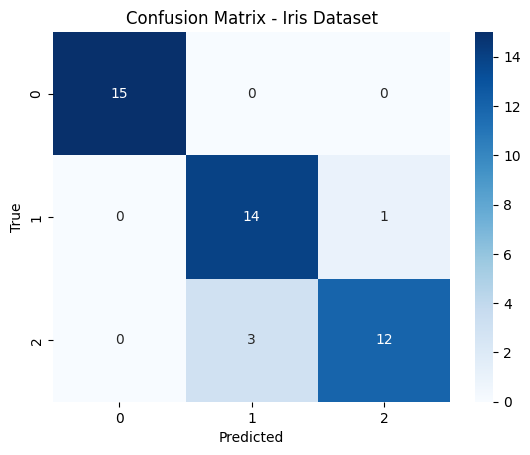

In [40]:

# ===== STUDENT CODE START =====
cm_iris = confusion_matrix(y_test_iris, y_pred_iris)
accuracy_iris = accuracy_score(y_test_iris, y_pred_iris)
precision_macro_iris = precision_score(y_test_iris, y_pred_iris, average='macro')
precision_micro_iris = precision_score(y_test_iris, y_pred_iris, average='micro')
precision_weighted_iris = precision_score(y_test_iris, y_pred_iris, average='weighted')
recall_macro_iris = recall_score(y_test_iris, y_pred_iris, average='macro')
recall_micro_iris = recall_score(y_test_iris, y_pred_iris, average='micro')
recall_weighted_iris = recall_score(y_test_iris, y_pred_iris, average='weighted')
f1_macro_iris = f1_score(y_test_iris, y_pred_iris, average='macro')
f1_micro_iris = f1_score(y_test_iris, y_pred_iris, average='micro')
f1_weighted_iris = f1_score(y_test_iris, y_pred_iris, average='weighted')
# ===== END CODE START =====

# Print results
print("="*60)
print("IRIS DATASET - Multiclass Classification Metrics")
print("="*60)
print("\nConfusion Matrix:")
print(cm_iris)
print(f"\nOverall Accuracy: {accuracy_iris:.4f}")
print("\nPrecision:")
print(f"  Macro:    {precision_macro_iris:.4f}")
print(f"  Micro:    {precision_micro_iris:.4f}")
print(f"  Weighted: {precision_weighted_iris:.4f}")
print("\nRecall:")
print(f"  Macro:    {recall_macro_iris:.4f}")
print(f"  Micro:    {recall_micro_iris:.4f}")
print(f"  Weighted: {recall_weighted_iris:.4f}")
print("\nF1-Score:")
print(f"  Macro:    {f1_macro_iris:.4f}")
print(f"  Micro:    {f1_micro_iris:.4f}")
print(f"  Weighted: {f1_weighted_iris:.4f}")

# Visualize Confusion Matrix 
# make a heatmap of the confusion matrix
sns.heatmap(cm_iris, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Iris Dataset')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ===== STUDENT CODE START =====
# ===== END CODE START =====


---
## ✏️ Part 3: Cross-Validation with Confidence Intervals

### Exercise 5: K-Fold Cross-Validation with Confidence Intervals

**Task:** Perform stratified k-fold cross-validation on both datasets and calculate 95% confidence intervals for the F1-scores.

**Requirements:**
1. Use 5-fold stratified cross-validation
2. Calculate cross-validation F1-scores for both Titanic and Iris datasets
3. For each dataset, compute:
   - Mean F1-score
   - Standard deviation
   - 95% confidence interval using the t-distribution

*Tip: Cross-validation returns an array of scores (one per fold). The standard error (SE) is calculated as std/sqrt(n) where n is the number of folds. For a 95% confidence interval with a t-distribution, you'll need the degrees of freedom (n-1). Consider using `scipy.stats.t.interval()`. For F1-score with binary classification, use `scoring='f1'`. For multiclass, use `scoring='f1_macro'`.*

In [41]:
# ===== STUDENT CODE START =====
# stratify the data into 5 fold cross validation on both datasets
from sklearn.model_selection import StratifiedKFold, cross_val_score
cv_scores_titanic = cross_val_score(model_titanic, X_titanic, y_titanic, cv=StratifiedKFold(n_splits=5), scoring='f1')
cv_scores_iris = cross_val_score(model_iris, X_iris, y_iris, cv=StratifiedKFold(n_splits=5), scoring='f1_macro')

# confidance interval for titanic dataset (binary)
ci_titanic = stats.t.interval(0.95, len(cv_scores_titanic)-1, loc=np.mean(cv_scores_titanic), scale=stats.sem(cv_scores_titanic))

# confidance interval and stats for iris dataset (multiclass)
cv_scores_iris = cross_val_score(model_iris, X_iris, y_iris, cv=StratifiedKFold(n_splits=5), scoring='f1_macro')
mean_iris = cv_scores_iris.mean()
ci_iris = stats.t.interval(0.95, len(cv_scores_iris)-1, loc=np.mean(cv_scores_iris), scale=stats.sem(cv_scores_iris))

# print the results
print(f"________________ Titanic ________________")
print(f"Titanic CV F1 Scores: {cv_scores_titanic}")
print(f"Titanic CV F1 Score Mean: {cv_scores_titanic.mean():.4f}")
print(f"Titanic CV F1 Score 95% CI: ({ci_titanic[0]:.4f}, {ci_titanic[1]:.4f})")
print(f"________________ Iris ________________")
print(f"Iris CV F1 Scores: {cv_scores_iris}")
print(f"Iris CV F1 Score Mean: {mean_iris:.4f}")
print(f"Iris CV F1 Score 95% CI: ({ci_iris[0]:.4f}, {ci_iris[1]:.4f})")

# ===== STUDENT CODE END =====

________________ Titanic ________________
Titanic CV F1 Scores: [0.72857143 0.71641791 0.72058824 0.672      0.75968992]
Titanic CV F1 Score Mean: 0.7195
Titanic CV F1 Score 95% CI: (0.6804, 0.7585)
________________ Iris ________________
Iris CV F1 Scores: [0.96658312 1.         0.93265993 0.89974937 1.        ]
Iris CV F1 Score Mean: 0.9598
Iris CV F1 Score 95% CI: (0.9056, 1.0140)
